In [3]:
# Imports
import pickle
import itertools
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans

In [4]:
pwd

'C:\\Users\\rhlgr\\FedAIC1.0\\TabularAIC1\\Preprocessing'

In [5]:
df = pd.read_csv('../Datasets/MIMICtable_261219.csv')

In [6]:
# I want to see the columns that are currently present.

df.columns

Index(['bloc', 'icustayid', 'charttime', 'timeday', 'dayweek', 'gender', 'age',
       'elixhauser', 're_admission', 'died_in_hosp',
       'died_within_48h_of_out_time', 'mortality_90d',
       'delay_end_of_record_and_discharge_or_death', 'Weight_kg', 'GCS', 'HR',
       'SysBP', 'MeanBP', 'DiaBP', 'RR', 'SpO2', 'Temp_C', 'FiO2_1',
       'Potassium', 'Sodium', 'Chloride', 'Glucose', 'BUN', 'Creatinine',
       'Magnesium', 'Calcium', 'Ionised_Ca', 'CO2_mEqL', 'SGOT', 'SGPT',
       'Total_bili', 'Albumin', 'Hb', 'WBC_count', 'Platelets_count', 'PTT',
       'PT', 'INR', 'Arterial_pH', 'paO2', 'paCO2', 'Arterial_BE',
       'Arterial_lactate', 'HCO3', 'mechvent', 'rrt', 'Shock_Index',
       'PaO2_FiO2', 'HRmin', 'SysBPmin', 'MeanBPmin', 'DiaBPmin', 'RRmin',
       'HRmax', 'SysBPmax', 'MeanBPmax', 'DiaBPmax', 'RRmax', 'HRsd',
       'SysBPsd', 'MeanBPsd', 'DiaBPsd', 'RRsd', 'median_dose_vaso',
       'max_dose_vaso', 'sedation', 'input_total', 'input_4hourly',
       'output_total',

In [7]:
# This tells us the number of unique patients in the dataset.

len(df['icustayid'].unique())

20846

In [9]:
# Here, we add two extra columns to the dataframe, one for the fluid resuscitation and one for the vasopressor dose.
# These are represented by a numerical scale from 1 to 5, with 1 being the lowest and 5 the highest.

def label_fluid (row):
    if row['input_4hourly'] == 0:
        return 1
    elif row['input_4hourly'] < 50:
        return 2
    elif row['input_4hourly'] < 180:
        return 3
    elif row['input_4hourly'] < 530:
        return 4
    else:
        return 5

df['fluid'] = df.apply(lambda row: label_fluid(row), axis=1)

def label_vaso (row):
    if row['median_dose_vaso'] == 0:
        return 1
    elif row['median_dose_vaso'] < 0.08:
        return 2
    elif row['median_dose_vaso'] < 0.22:
        return 3
    elif row['median_dose_vaso'] < 0.45:
        return 4
    else:
        return 5

df['vaso'] = df.apply(lambda row: label_vaso(row), axis=1)

# We verify by checking the first few rows of the dataframe, but only the relevant columns.
df[['icustayid', 'input_4hourly', 'median_dose_vaso', 'fluid', 'vaso']].head()

,icustayid,input_4hourly,median_dose_vaso,fluid,vaso
0,3,20.0,0.0,2,1
1,3,20.0,0.0,2,1
2,3,20.0,0.0,2,1
3,3,20.0,0.0,2,1
4,3,20.0,0.0,2,1


In [13]:
# Since we are using RL to optimise the median dose of vasopressors and fluid levels, we want
# to optimise `fluid` and `vaso` as well. We will first determine a set of actions for each of these:

# First, we need to determine the number of unique combinations of `fluid` and `vaso` that we have in the dataset.
conditions = [a & b for a in [df["fluid"] == ap for ap in range(1, 6)] for b in [df["vaso"] == bp for bp in range(1, 6)]]

# We then enumerate the conditions to get a list of unique combinations.
choices = [i for i in range(1, 26)]

# We then add a new column to the dataframe, which will contain the action number for each combination of `fluid` and `vaso`.
# This represents the action that was taken in the dataset.
df['action'] = np.select(conditions, choices, default=np.nan)
df['action'] = df['action'].astype(int)

# We create a reverse mapping of actions to `fluid` and `vaso` levels:
reverse_mapping = {i: (a, b) for i, (a, b) in zip(choices, list(itertools.product(range(1, 6), range(1, 6))))}

# Finally, we just have some generic amounts for the fluid and vaso levels corresponding to the action numbers.
fluid_levels = [0, 8, 21, 80, 237]
vaso_levels = [0, 0.04, 0.13, 0.27, 0.68]

In [14]:
# Here are some standardisations to deal with nicer units.

df.columns = map(str.lower, df.columns)

df['age'] = df['age'].apply(lambda x: x / 365.25)
df['creatinine'] = df['creatinine'].apply(lambda x: x* 88.4)
df['total_bili'] = df['total_bili'].apply(lambda x: x* 17.1)
df['bun'] = df['bun'].apply(lambda x: x* 0.3571)
df['albumin'] = df['albumin'].apply(lambda x: x* 10)
df['cumulated_balance'] = df['cumulated_balance'].apply(lambda x: x* 0.001)
df['pao2'] = df['pao2'].apply(lambda x: x * 0.133322)
df['paco2'] = df['paco2'].apply(lambda x: x * 0.133322)
df['glucose'] = df['glucose'].apply(lambda x: x / 18)
df['calcium'] = df['calcium'].apply(lambda x: x * 0.2495)
df['input_4hourly'] = df['input_4hourly'].apply(lambda x: x / 4)
df['output_4hourly'] = df['output_4hourly'].apply(lambda x: x / 4)

In [15]:
# We round the data to 2 DPs.
df = df.round(2)

# Data which should be integers are converted to integers.
int_cols = ['bloc', 'icustayid', 'age', 'elixhauser', 're_admission', 'weight_kg', 'gcs', 
            'hr', 'meanbp', 'sysbp', 'diabp', 'rr', 'spo2', 'bun', 'creatinine', 'sgpt', 
            'total_bili', 'albumin', 'hco3', 'mechvent', 'input_4hourly',  
            'output_4hourly', 'sodium', 'chloride', 'action', 'platelets_count', 'sofa']
df[int_cols] = df[int_cols].astype(np.int64)

# Data which should have one/two decimal place are restricted to have that many.
one_dp_cols = ['temp_c', 'arterial_be', 'arterial_lactate', 'potassium', 'glucose', 'magnesium', 
               'cumulated_balance', 'wbc_count', 'ptt', 'pt', 'inr']
two_dp_cols = ['fio2_1', 'arterial_ph', 'median_dose_vaso', 'hb', 'calcium']

df[one_dp_cols] = df[one_dp_cols].apply(lambda x: round(x, 1))
df[two_dp_cols] = df[two_dp_cols].apply(lambda x: round(x, 2))

In [16]:
df.head()

,bloc,icustayid,charttime,timeday,dayweek,gender,age,elixhauser,re_admission,died_in_hosp,...,input_total,input_4hourly,output_total,output_4hourly,cumulated_balance,sofa,sirs,fluid,vaso,action
0,1,3,7245486000,19,4,0,48,0,0,0,...,6497.0,5,13197.0,25,-6.7,5,2,2,1,6
1,2,3,7245489600,20,4,0,48,0,0,0,...,6517.0,5,13397.0,50,-6.9,6,2,2,1,6
2,3,3,7245493200,21,4,0,48,0,0,0,...,6537.0,5,13757.0,90,-7.2,6,2,2,1,6
3,4,3,7245496800,22,4,0,48,0,0,0,...,6557.0,5,14077.0,80,-7.5,5,2,2,1,6
4,5,3,7245500400,23,4,0,48,0,0,0,...,6577.0,5,14197.0,30,-7.6,5,2,2,1,6


In [18]:
# Using only the specified columns.

df = df[df.columns[df.columns.isin(['bloc', 'icustayid', 'gender', 'age', 'elixhauser',
               're_admission', 'mortality_90d', 'weight_kg', 'gcs', 'hr', 'sysbp', 'diabp',
               'meanbp', 'rr', 'spo2', 'temp_c', 'fio2_1',  'bun', 'creatinine', 'potassium', 
               'sodium', 'chloride', 'glucose', 'bun', 'creatinine', 'magnesium', 'calcium',
               'sgpt', 'total_bili', 'albumin', 'hb', 'wbc_count', 'arterial_ph', 
               'arterial_be', 'arterial_lactate', 'hco3', 'mechvent', 'median_dose_vaso', 
               'input_4hourly', 'output_4hourly', 'cumulated_balance', 'ovaso', 'ofluid', 
               'state', 'fluid', 'vaso', 'action', 'pao2', 'paco2', 'platelets_count', 'pt', 'ptt', 'inr'])]]

# Renaming them.
df = df.rename(columns={"bloc": "timestep", "icustayid": "episode", "elixhauser": "elix", "re_admission": "readm", 
                  "mortality_90d": "dead", "weight_kg": "wt", "meanbp": "map", "sysbp": "sbp", "diabp": "dbp", 
                  "temp_c": "temp", "fio2_1": "fio2", "sodium": "na", "potassium": "k", "chloride": "cl", 
                  "glucose": "glu", "calcium": "ca", "magnesium": "mg", "platelets_count": "plt",
                  "bun": "urea", "creatinine": "creat", "sgpt": "alt", "total_bili": "bili", "albumin": "alb", 
                  "wbc_count": "wcc", "arterial_ph": "ph", "arterial_be": "be", "arterial_lactate": "lac", 
                  "mechvent": "vent", "median_dose_vaso": "norad", "input_4hourly": "in", "output_4hourly": "out", 
                  "cumulated_balance": "balance", "ptt": "aptt", "pao2": "po2", "paco2": "pco2"})

In [21]:
df.columns

Index(['timestep', 'episode', 'gender', 'age', 'elix', 'readm', 'dead', 'wt',
       'gcs', 'hr', 'sbp', 'map', 'dbp', 'rr', 'spo2', 'temp', 'fio2', 'k',
       'na', 'cl', 'glu', 'urea', 'creat', 'mg', 'ca', 'alt', 'bili', 'alb',
       'hb', 'wcc', 'plt', 'aptt', 'pt', 'inr', 'ph', 'po2', 'pco2', 'be',
       'lac', 'hco3', 'vent', 'norad', 'in', 'out', 'balance', 'fluid', 'vaso',
       'action'],
      dtype='object')

In [23]:
dfc = df.drop(['episode', 'readm', 'dead', 'fluid', 'vaso', 'action'],axis=1)

# Performs data preprocessing:
#   Yeo-Johnson transformation for non-normally distributed columns
#   Centering binary variables around zero
#   Storing the lambda values used for transformations

def inverse_yeojohnson(y, lmbda):
    x = np.empty_like(y)
    pos = y >= 0
    neg = ~pos

    x[pos & (lmbda != 0)] = ((y[pos & (lmbda != 0)] * lmbda) + 1) ** (1 / lmbda) - 1
    x[neg & (lmbda != 0)] = -((-y[neg & (lmbda != 0)] * lmbda) + 1) ** (1 / lmbda) + 1
    x[pos & (lmbda == 0)] = np.exp(y[pos & (lmbda == 0)]) - 1
    x[neg & (lmbda == 0)] = -(-np.exp(-y[neg & (lmbda == 0)]) + 1)

    return x

lambdas = {}
col_tran = ['timestep','gcs','spo2','fio2','urea','creat','alt','bili','pt','inr','aptt','lac','norad','in','out']
for col in col_tran:
    dfc[col], lambdas[col] = stats.yeojohnson(dfc[col])

dfc['vent'] = dfc['vent'] - 0.5
dfc['gender'] = dfc['gender'] - 0.5

In [24]:
# First, we standardise the data.
scaler = StandardScaler()
dfc_sc = scaler.fit_transform(dfc)

# Finally, we perform KMeans clustering on the data.
model = KMeans(n_clusters=750, verbose=1, random_state=42, n_init=10)
cluster_labels = model.fit_predict(dfc_sc)

Initialization complete
Iteration 0, inertia 29049782.546723116.
Iteration 1, inertia 23919939.843900036.
Iteration 2, inertia 23307754.263515864.
Iteration 3, inertia 23038663.279551692.
Iteration 4, inertia 22881250.22285432.
Iteration 5, inertia 22776284.022073463.
Iteration 6, inertia 22701788.400387198.
Iteration 7, inertia 22645713.068063796.
Iteration 8, inertia 22601354.48845929.
Iteration 9, inertia 22565691.94392161.
Iteration 10, inertia 22535077.84060163.
Iteration 11, inertia 22507882.427351438.
Iteration 12, inertia 22485195.97278353.
Iteration 13, inertia 22465978.340954553.
Iteration 14, inertia 22448900.65524281.
Iteration 15, inertia 22434181.787276894.
Iteration 16, inertia 22421495.64822425.
Iteration 17, inertia 22410010.232549183.
Iteration 18, inertia 22399426.63438369.
Iteration 19, inertia 22389827.21416916.
Iteration 20, inertia 22380734.553511865.
Iteration 21, inertia 22372022.93012614.
Iteration 22, inertia 22364614.64211891.
Iteration 23, inertia 22358356.

In [25]:
dfc['st'] = cluster_labels.tolist()

df['st'] = dfc['st']
df = df.rename(columns={"state": "old_st", "st": "state"})

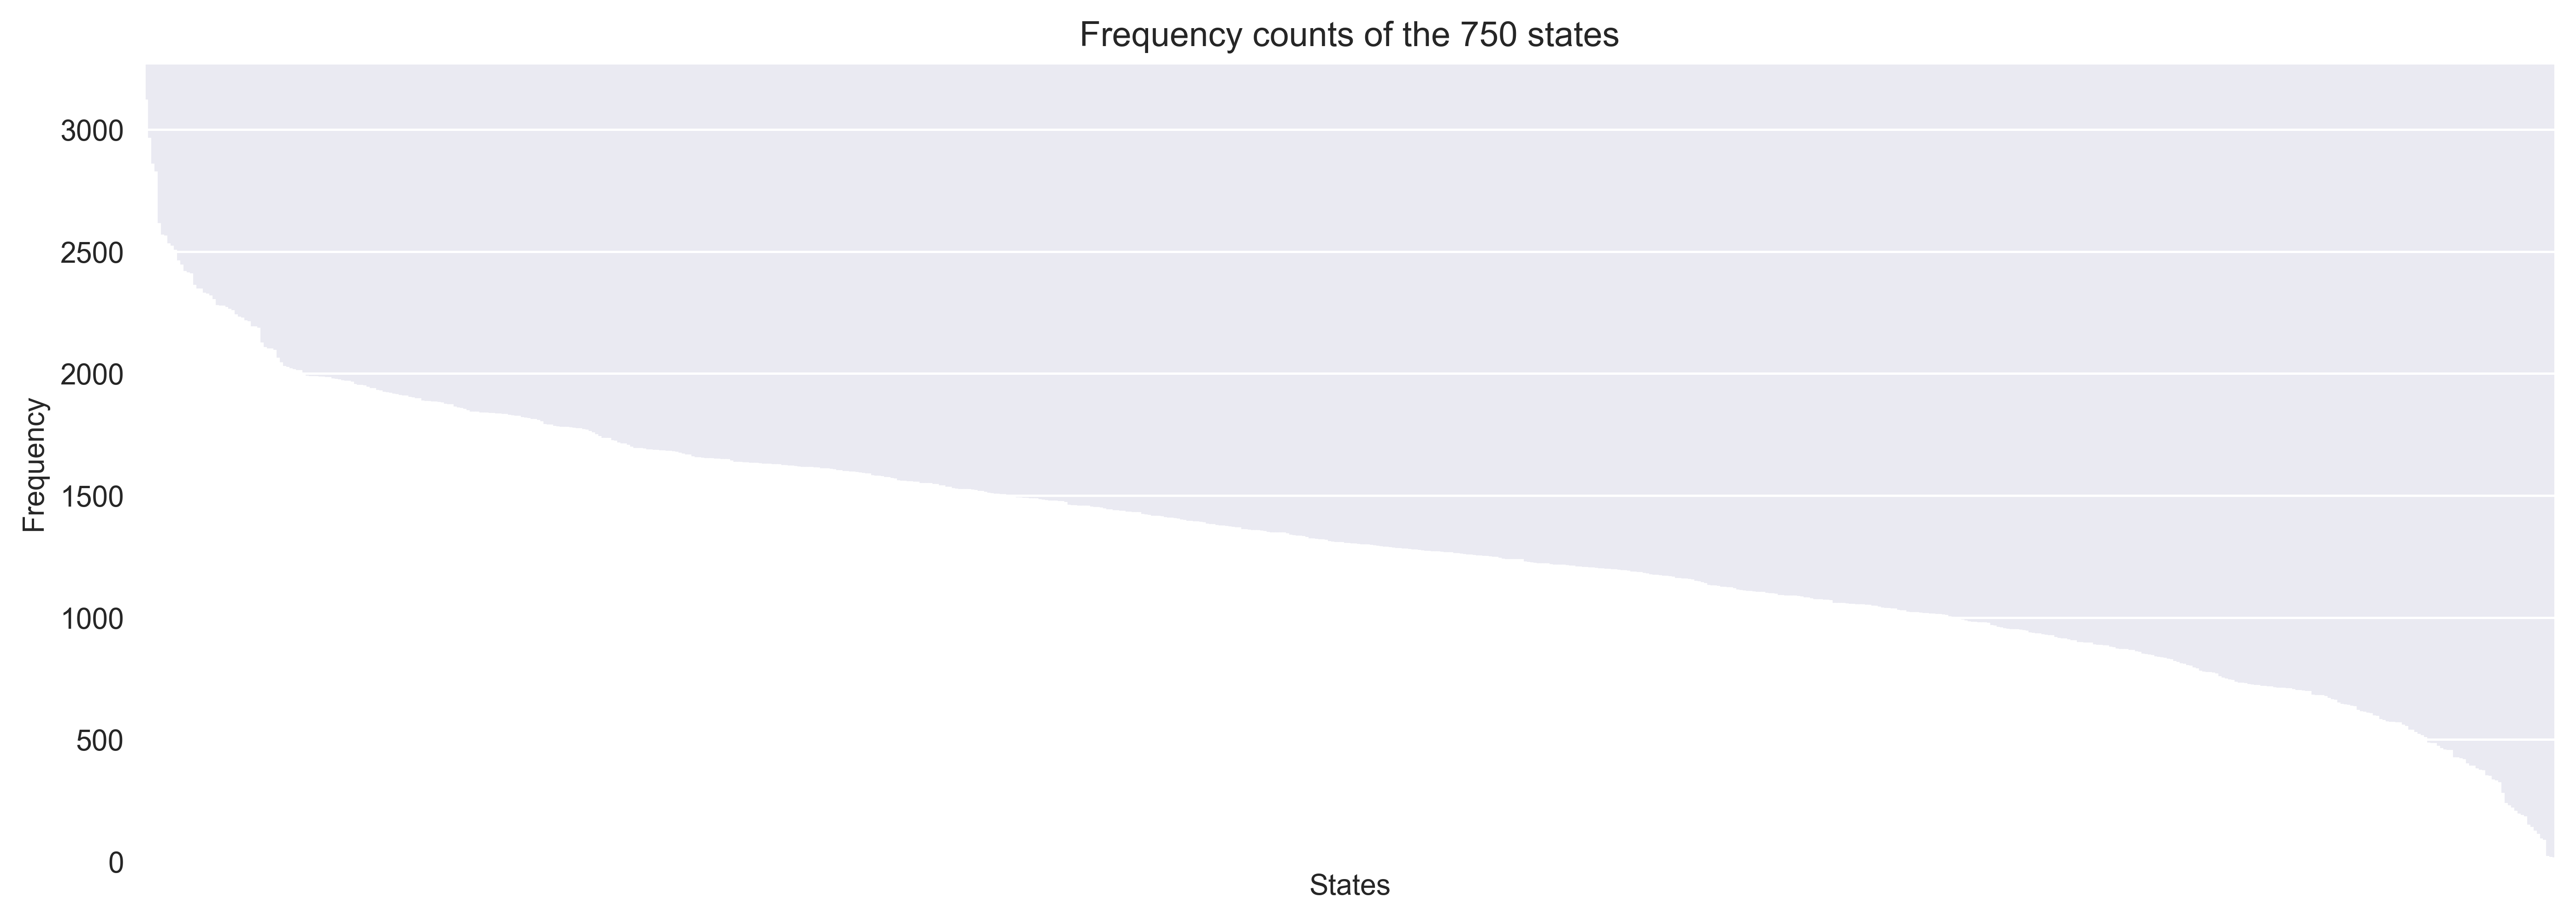

In [26]:
plt.figure(figsize=(15, 5), dpi=450)
dfc['st'].value_counts().plot(kind='bar')
plt.xlabel('States')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.xticks([])
plt.title('Frequency counts of the 750 states')
plt.show();

In [28]:
dfrl = df[['timestep','episode','dead','state','action']]

def add_row(x):
    if (x['timestep'].max()):
        last_row = x.iloc[-1:]
        return pd.concat([x, last_row], ignore_index=True)
    return x

def edit_row(x):
    if (x['timestep'].max()):
        idx = x.index[-1]
        x.loc[idx, 'timestep'] += 1
        x.loc[idx, 'dead'] -= 101
        x.loc[idx, 'state'] = 777
    return x

dfrl = dfrl.groupby('episode', group_keys=False).apply(add_row).reset_index(drop=True)
dfrl = dfrl.groupby('episode', group_keys=False).apply(edit_row).reset_index(drop=True)

dfrl['state'] = np.where(dfrl['dead'] == -100, 752, dfrl['state']) #death
dfrl['state'] = np.where(dfrl['dead'] == -101, 751, dfrl['state']) #survival

dfrl['dead'] = np.where(dfrl['dead']==-101, 100, dfrl['dead'])
dfrl['dead'] = np.where(dfrl['dead']==1, 0, dfrl['dead'])

dfrl['action'] = np.where(dfrl['state']==751, np.nan, dfrl['action'])
dfrl['action'] = np.where(dfrl['state']==752, np.nan, dfrl['action'])

df_history = dfrl.rename(columns={'dead': 'reward'})
df_history.to_csv('df_history.csv')

C:\Users\rhlgr\AppData\Local\Temp\ipykernel_13296\4195152519.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfrl = dfrl.groupby('episode', group_keys=False).apply(add_row).reset_index(drop=True)
C:\Users\rhlgr\AppData\Local\Temp\ipykernel_13296\4195152519.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfrl = dfrl.groupby('episode', group_keys=False).apply(edit_row).reset_index(drop=True)


In [29]:
pwd

'C:\\Users\\rhlgr\\FedAIC1.0\\TabularAIC1\\Preprocessing'

In [6]:
# More processing.
df = pd.read_csv('./df_history.csv', index_col=0)
df.head()

,timestep,episode,reward,state,action
0,1,3,0.0,457,6.0
1,2,3,0.0,457,6.0
2,3,3,0.0,457,6.0
3,4,3,0.0,457,6.0
4,5,3,0.0,488,6.0


In [7]:
df['next_state'] = df.groupby('episode')['state'].shift(-1)
df['done'] = df['action'].isna().astype(int)
df.head(100).to_csv('df_temp.csv')

In [10]:
df = pd.read_csv('./df_temp.csv', index_col=0)
df.head(100)

,timestep,episode,reward,state,action,next_state,done
0,1,3,0.0,457,6.0,457.0,0
1,2,3,0.0,457,6.0,457.0,0
2,3,3,0.0,457,6.0,457.0,0
3,4,3,0.0,457,6.0,488.0,0
4,5,3,0.0,488,6.0,488.0,0
...,...,...,...,...,...,...,...
95,18,14,0.0,0,1.0,203.0,0
96,19,14,0.0,203,1.0,203.0,0
97,20,14,0.0,203,1.0,203.0,0
98,21,14,0.0,203,1.0,203.0,0


In [11]:
terminal_indices = df.index[df['done'] == 1].tolist()
for idx in terminal_indices:
    df.loc[idx - 1, 'reward'] = df.loc[idx, 'reward']
    df.loc[idx - 1, 'done'] = df.loc[idx, 'done']
df = df.drop(terminal_indices).reset_index(drop=True)
df.head(100).to_csv('df_collapsed_terminals.csv')
df.head(100)

,timestep,episode,reward,state,action,next_state,done
0,1,3,0.0,457,6.0,457.0,0
1,2,3,0.0,457,6.0,457.0,0
2,3,3,0.0,457,6.0,457.0,0
3,4,3,0.0,457,6.0,488.0,0
4,5,3,0.0,488,6.0,488.0,0
...,...,...,...,...,...,...,...
92,18,14,0.0,0,1.0,203.0,0
93,19,14,0.0,203,1.0,203.0,0
94,20,14,0.0,203,1.0,203.0,0
95,21,14,0.0,203,1.0,203.0,0


In [12]:
column_order = ['episode', 'timestep', 'reward', 'state', 'action', 'next_state', 'done']
df = df[column_order]
df.to_csv('df_final.csv')

In [13]:
df.head(100)

,episode,timestep,reward,state,action,next_state,done
0,3,1,0.0,457,6.0,457.0,0
1,3,2,0.0,457,6.0,457.0,0
2,3,3,0.0,457,6.0,457.0,0
3,3,4,0.0,457,6.0,488.0,0
4,3,5,0.0,488,6.0,488.0,0
...,...,...,...,...,...,...,...
92,14,18,0.0,0,1.0,203.0,0
93,14,19,0.0,203,1.0,203.0,0
94,14,20,0.0,203,1.0,203.0,0
95,14,21,0.0,203,1.0,203.0,0


In [22]:
exps = df.sample(8)

for index, row in exps.iterrows():
    print(row["timestep"])

14.0
14.0
13.0
30.0
35.0
5.0
7.0
1.0
